# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper
import image
helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

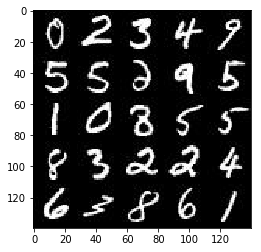

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

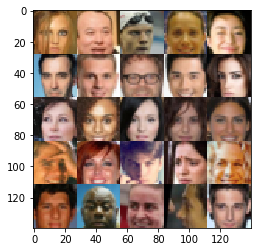

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_image = tf.placeholder(tf.float32,(None,image_width, image_height,image_channels), name = 'real_image')
    z = tf.placeholder(tf.float32,(None, z_dim), name = 'input')
    learing_rate = tf.placeholder(tf.float32,name ='learning_rate')

    return real_image, z, learing_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator',reuse = reuse):
        x1 = tf.layers.conv2d(images,64,5,strides = 2, padding = "same")
        relu1 = tf.maximum(0.05 * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same')
        bn2 = tf.layers.batch_normalization(x2, training = True)
        relu2 = tf.maximum(0.1 * bn2, bn2)
        
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same')
        bn3 = tf.layers.batch_normalization(x3, training = True)
        relu3 = tf.maximum(0.2 * bn3, bn3)

        flat = tf.reshape(relu3, (-1, 4 * 4 * 256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse = not is_train):
        x1 = tf.layers.dense(z, 4 * 4 * 256)
        x1 = tf.reshape(x1, (-1, 4, 4, 256))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(0.05 * x1, x1)

        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.1 * x2, x2)
        
        # 7x7x256 now
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(0.2 * x3, x3)
        # 14x14x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding='same')
        # 28 x28 xout_channel_dim now

        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)    
    d_model_fake, d_logits_fake = discriminator(g_model,reuse=True)

    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake   
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1 = beta1).minimize(d_loss, var_list = d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate * 1.2, beta1 = beta1).minimize(g_loss, var_list = g_vars)
     
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    steps = 0
    image_channels = 3 if data_image_mode == 'RGB' else 1
    image_width = data_shape[1]
    image_height = data_shape[2]
    input_real,input_z,lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss,g_loss = model_loss(input_real, input_z, data_shape[3])
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images.reshape(batch_size,data_shape[1],data_shape[2],data_shape[3])
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1,1,size = (batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict = {input_real: batch_images, input_z : batch_z, lr: learning_rate})
                _ = sess.run(g_train_opt, feed_dict = {input_real: batch_images, input_z : batch_z, lr: learning_rate})
                
                if steps %10 == 0 :
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print ("Epoch {}/{} ...".format(epoch_i + 1, epoch_count),
                           "Discriminator Loss: {:.4f}".format(train_loss_d),
                           "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    
                if steps %100 == 0:
                    show_generator_output(sess, 25, input_z, data_shape[3],data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2 ... Discriminator Loss: 7.0272 Generator Loss: 8.9660
Epoch 1/2 ... Discriminator Loss: 0.8742 Generator Loss: 2.1641
Epoch 1/2 ... Discriminator Loss: 0.8356 Generator Loss: 2.3475
Epoch 1/2 ... Discriminator Loss: 0.5428 Generator Loss: 1.1410
Epoch 1/2 ... Discriminator Loss: 0.7231 Generator Loss: 1.4253
Epoch 1/2 ... Discriminator Loss: 3.4834 Generator Loss: 8.8382
Epoch 1/2 ... Discriminator Loss: 0.7701 Generator Loss: 4.5138
Epoch 1/2 ... Discriminator Loss: 1.2362 Generator Loss: 1.0744
Epoch 1/2 ... Discriminator Loss: 0.2871 Generator Loss: 1.9625
Epoch 1/2 ... Discriminator Loss: 0.6936 Generator Loss: 1.1683


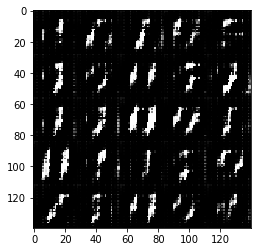

Epoch 1/2 ... Discriminator Loss: 1.6159 Generator Loss: 2.4323
Epoch 1/2 ... Discriminator Loss: 2.2019 Generator Loss: 0.2611
Epoch 1/2 ... Discriminator Loss: 1.5924 Generator Loss: 0.3204
Epoch 1/2 ... Discriminator Loss: 1.1357 Generator Loss: 2.7772
Epoch 1/2 ... Discriminator Loss: 1.5688 Generator Loss: 3.1651
Epoch 1/2 ... Discriminator Loss: 1.0967 Generator Loss: 2.3169
Epoch 1/2 ... Discriminator Loss: 1.5543 Generator Loss: 1.5469
Epoch 1/2 ... Discriminator Loss: 1.3707 Generator Loss: 0.5369
Epoch 1/2 ... Discriminator Loss: 0.8560 Generator Loss: 1.4031
Epoch 1/2 ... Discriminator Loss: 0.6707 Generator Loss: 1.6763


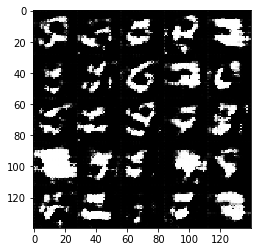

Epoch 1/2 ... Discriminator Loss: 0.8204 Generator Loss: 1.4052
Epoch 1/2 ... Discriminator Loss: 1.1767 Generator Loss: 1.2281
Epoch 1/2 ... Discriminator Loss: 0.6884 Generator Loss: 1.5224
Epoch 1/2 ... Discriminator Loss: 1.2005 Generator Loss: 1.1996
Epoch 1/2 ... Discriminator Loss: 1.1010 Generator Loss: 1.9017
Epoch 1/2 ... Discriminator Loss: 0.6703 Generator Loss: 1.5777
Epoch 1/2 ... Discriminator Loss: 1.2760 Generator Loss: 1.2360
Epoch 1/2 ... Discriminator Loss: 1.3278 Generator Loss: 2.3827
Epoch 1/2 ... Discriminator Loss: 1.2115 Generator Loss: 0.6910
Epoch 1/2 ... Discriminator Loss: 1.1879 Generator Loss: 1.8095


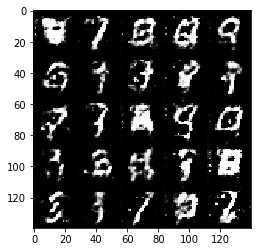

Epoch 1/2 ... Discriminator Loss: 1.4463 Generator Loss: 0.5709
Epoch 1/2 ... Discriminator Loss: 1.4139 Generator Loss: 0.5908
Epoch 1/2 ... Discriminator Loss: 2.9964 Generator Loss: 0.0942
Epoch 1/2 ... Discriminator Loss: 1.1494 Generator Loss: 1.0223
Epoch 1/2 ... Discriminator Loss: 1.1887 Generator Loss: 0.6485
Epoch 1/2 ... Discriminator Loss: 1.1257 Generator Loss: 0.6533
Epoch 1/2 ... Discriminator Loss: 1.2477 Generator Loss: 0.5868
Epoch 1/2 ... Discriminator Loss: 0.8242 Generator Loss: 0.7703
Epoch 1/2 ... Discriminator Loss: 1.3526 Generator Loss: 0.4686
Epoch 1/2 ... Discriminator Loss: 1.8195 Generator Loss: 0.3427


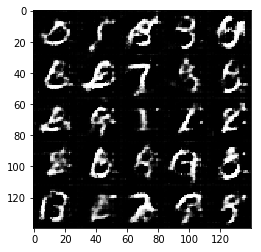

Epoch 1/2 ... Discriminator Loss: 0.6988 Generator Loss: 0.9230
Epoch 1/2 ... Discriminator Loss: 1.2556 Generator Loss: 0.6896
Epoch 1/2 ... Discriminator Loss: 1.3748 Generator Loss: 0.6473
Epoch 1/2 ... Discriminator Loss: 1.1918 Generator Loss: 1.9516
Epoch 1/2 ... Discriminator Loss: 1.8518 Generator Loss: 0.2619
Epoch 1/2 ... Discriminator Loss: 1.4120 Generator Loss: 0.5314
Epoch 1/2 ... Discriminator Loss: 1.1742 Generator Loss: 0.4360
Epoch 1/2 ... Discriminator Loss: 1.2724 Generator Loss: 0.6675
Epoch 1/2 ... Discriminator Loss: 1.3612 Generator Loss: 0.4293
Epoch 1/2 ... Discriminator Loss: 1.4617 Generator Loss: 0.8567


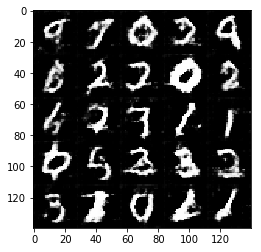

Epoch 1/2 ... Discriminator Loss: 1.8556 Generator Loss: 2.0230
Epoch 1/2 ... Discriminator Loss: 1.5182 Generator Loss: 0.4538
Epoch 1/2 ... Discriminator Loss: 1.1228 Generator Loss: 0.8679
Epoch 1/2 ... Discriminator Loss: 1.1035 Generator Loss: 0.5163
Epoch 1/2 ... Discriminator Loss: 1.6019 Generator Loss: 0.4877
Epoch 1/2 ... Discriminator Loss: 1.0940 Generator Loss: 0.6624
Epoch 1/2 ... Discriminator Loss: 1.3016 Generator Loss: 0.7910
Epoch 1/2 ... Discriminator Loss: 1.4876 Generator Loss: 0.4279
Epoch 1/2 ... Discriminator Loss: 1.8443 Generator Loss: 0.2714
Epoch 1/2 ... Discriminator Loss: 1.0758 Generator Loss: 0.6079


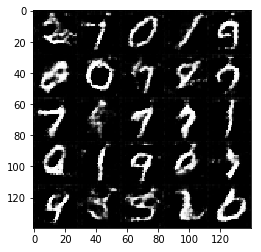

Epoch 1/2 ... Discriminator Loss: 1.8848 Generator Loss: 0.3248
Epoch 1/2 ... Discriminator Loss: 1.3910 Generator Loss: 0.4082
Epoch 1/2 ... Discriminator Loss: 1.2994 Generator Loss: 0.9906
Epoch 1/2 ... Discriminator Loss: 1.3536 Generator Loss: 0.5403
Epoch 1/2 ... Discriminator Loss: 1.2416 Generator Loss: 0.5522
Epoch 1/2 ... Discriminator Loss: 1.0778 Generator Loss: 0.6343
Epoch 1/2 ... Discriminator Loss: 1.0696 Generator Loss: 1.0687
Epoch 1/2 ... Discriminator Loss: 1.8598 Generator Loss: 0.2811
Epoch 1/2 ... Discriminator Loss: 1.1281 Generator Loss: 0.7361
Epoch 1/2 ... Discriminator Loss: 1.4613 Generator Loss: 0.4926


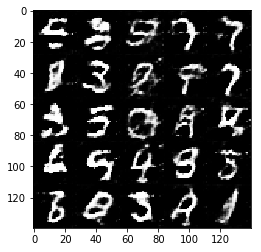

Epoch 1/2 ... Discriminator Loss: 1.3967 Generator Loss: 0.6581
Epoch 1/2 ... Discriminator Loss: 0.8382 Generator Loss: 0.8695
Epoch 1/2 ... Discriminator Loss: 1.4494 Generator Loss: 0.5000
Epoch 1/2 ... Discriminator Loss: 0.9140 Generator Loss: 1.0577
Epoch 1/2 ... Discriminator Loss: 1.1278 Generator Loss: 0.5939
Epoch 1/2 ... Discriminator Loss: 1.0801 Generator Loss: 0.7709
Epoch 1/2 ... Discriminator Loss: 1.0782 Generator Loss: 1.0861
Epoch 1/2 ... Discriminator Loss: 1.5019 Generator Loss: 2.1366
Epoch 1/2 ... Discriminator Loss: 1.3821 Generator Loss: 0.5108
Epoch 1/2 ... Discriminator Loss: 1.4188 Generator Loss: 0.4358


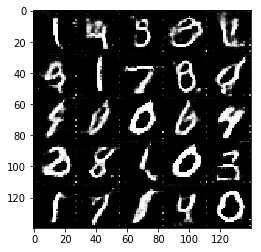

Epoch 1/2 ... Discriminator Loss: 1.3707 Generator Loss: 0.3998
Epoch 1/2 ... Discriminator Loss: 1.0422 Generator Loss: 0.8709
Epoch 1/2 ... Discriminator Loss: 1.2320 Generator Loss: 0.5075
Epoch 1/2 ... Discriminator Loss: 1.2580 Generator Loss: 0.5867
Epoch 1/2 ... Discriminator Loss: 1.7257 Generator Loss: 0.2993
Epoch 1/2 ... Discriminator Loss: 1.2741 Generator Loss: 0.5128
Epoch 1/2 ... Discriminator Loss: 1.6334 Generator Loss: 2.2149
Epoch 1/2 ... Discriminator Loss: 1.3941 Generator Loss: 0.4749
Epoch 1/2 ... Discriminator Loss: 1.0305 Generator Loss: 0.9489
Epoch 1/2 ... Discriminator Loss: 1.2773 Generator Loss: 1.1996


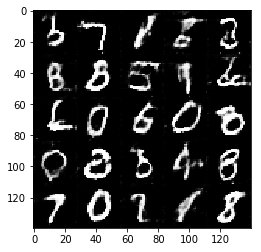

Epoch 1/2 ... Discriminator Loss: 1.3133 Generator Loss: 1.3497
Epoch 1/2 ... Discriminator Loss: 1.4437 Generator Loss: 0.8058
Epoch 1/2 ... Discriminator Loss: 2.1674 Generator Loss: 0.1660
Epoch 2/2 ... Discriminator Loss: 1.3303 Generator Loss: 0.4508
Epoch 2/2 ... Discriminator Loss: 1.4615 Generator Loss: 2.1272
Epoch 2/2 ... Discriminator Loss: 1.5403 Generator Loss: 0.4353
Epoch 2/2 ... Discriminator Loss: 1.7927 Generator Loss: 0.3720
Epoch 2/2 ... Discriminator Loss: 1.0568 Generator Loss: 1.1436
Epoch 2/2 ... Discriminator Loss: 1.2787 Generator Loss: 0.6154
Epoch 2/2 ... Discriminator Loss: 1.1418 Generator Loss: 1.2422


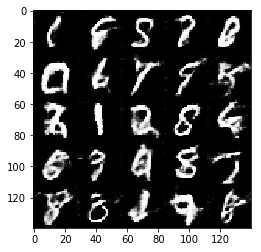

Epoch 2/2 ... Discriminator Loss: 0.8862 Generator Loss: 0.9243
Epoch 2/2 ... Discriminator Loss: 1.2074 Generator Loss: 0.6432
Epoch 2/2 ... Discriminator Loss: 1.1935 Generator Loss: 0.5330
Epoch 2/2 ... Discriminator Loss: 1.2193 Generator Loss: 2.0961
Epoch 2/2 ... Discriminator Loss: 1.7297 Generator Loss: 0.2883
Epoch 2/2 ... Discriminator Loss: 1.0783 Generator Loss: 0.6623
Epoch 2/2 ... Discriminator Loss: 1.0095 Generator Loss: 0.8292
Epoch 2/2 ... Discriminator Loss: 1.3185 Generator Loss: 0.5257
Epoch 2/2 ... Discriminator Loss: 1.3304 Generator Loss: 0.5282
Epoch 2/2 ... Discriminator Loss: 1.2872 Generator Loss: 0.5018


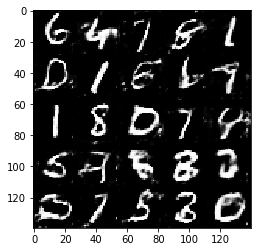

Epoch 2/2 ... Discriminator Loss: 0.6325 Generator Loss: 1.9465
Epoch 2/2 ... Discriminator Loss: 1.2870 Generator Loss: 0.4988
Epoch 2/2 ... Discriminator Loss: 1.3301 Generator Loss: 2.1410
Epoch 2/2 ... Discriminator Loss: 2.1521 Generator Loss: 0.1674
Epoch 2/2 ... Discriminator Loss: 1.0724 Generator Loss: 0.7296
Epoch 2/2 ... Discriminator Loss: 1.3160 Generator Loss: 2.4996
Epoch 2/2 ... Discriminator Loss: 1.4160 Generator Loss: 0.4159
Epoch 2/2 ... Discriminator Loss: 1.0695 Generator Loss: 0.9159
Epoch 2/2 ... Discriminator Loss: 0.9495 Generator Loss: 1.1939
Epoch 2/2 ... Discriminator Loss: 1.1447 Generator Loss: 1.1696


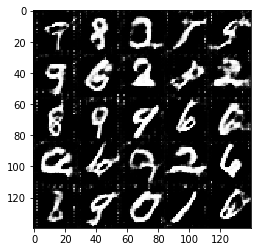

Epoch 2/2 ... Discriminator Loss: 1.1617 Generator Loss: 1.2669
Epoch 2/2 ... Discriminator Loss: 1.4795 Generator Loss: 0.4324
Epoch 2/2 ... Discriminator Loss: 1.1488 Generator Loss: 0.7230
Epoch 2/2 ... Discriminator Loss: 1.0127 Generator Loss: 0.7885
Epoch 2/2 ... Discriminator Loss: 2.9680 Generator Loss: 0.0686
Epoch 2/2 ... Discriminator Loss: 1.7814 Generator Loss: 0.2914
Epoch 2/2 ... Discriminator Loss: 1.1228 Generator Loss: 0.6081
Epoch 2/2 ... Discriminator Loss: 1.2070 Generator Loss: 1.5985
Epoch 2/2 ... Discriminator Loss: 0.5048 Generator Loss: 1.7463
Epoch 2/2 ... Discriminator Loss: 0.3262 Generator Loss: 1.8433


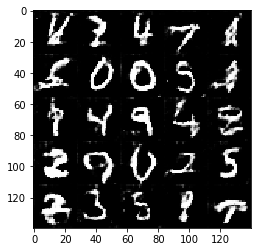

Epoch 2/2 ... Discriminator Loss: 1.3406 Generator Loss: 0.4568
Epoch 2/2 ... Discriminator Loss: 1.1303 Generator Loss: 1.3025
Epoch 2/2 ... Discriminator Loss: 1.6420 Generator Loss: 0.3379
Epoch 2/2 ... Discriminator Loss: 1.6746 Generator Loss: 0.3058
Epoch 2/2 ... Discriminator Loss: 1.8770 Generator Loss: 0.2348
Epoch 2/2 ... Discriminator Loss: 2.3759 Generator Loss: 0.1259
Epoch 2/2 ... Discriminator Loss: 1.0931 Generator Loss: 1.7437
Epoch 2/2 ... Discriminator Loss: 1.3430 Generator Loss: 0.4535
Epoch 2/2 ... Discriminator Loss: 1.2659 Generator Loss: 0.7733
Epoch 2/2 ... Discriminator Loss: 0.8800 Generator Loss: 0.9850


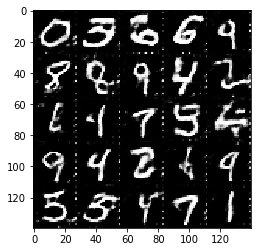

Epoch 2/2 ... Discriminator Loss: 1.0248 Generator Loss: 0.7061
Epoch 2/2 ... Discriminator Loss: 1.2284 Generator Loss: 0.5865
Epoch 2/2 ... Discriminator Loss: 1.8674 Generator Loss: 0.2493
Epoch 2/2 ... Discriminator Loss: 2.1857 Generator Loss: 0.1692
Epoch 2/2 ... Discriminator Loss: 0.5891 Generator Loss: 1.3228
Epoch 2/2 ... Discriminator Loss: 1.2038 Generator Loss: 2.4169
Epoch 2/2 ... Discriminator Loss: 1.9687 Generator Loss: 0.2757
Epoch 2/2 ... Discriminator Loss: 2.1216 Generator Loss: 0.2255
Epoch 2/2 ... Discriminator Loss: 0.8569 Generator Loss: 1.1224
Epoch 2/2 ... Discriminator Loss: 1.1757 Generator Loss: 0.5530


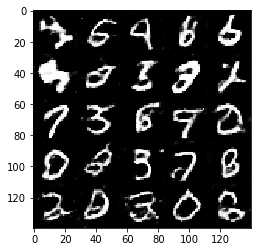

Epoch 2/2 ... Discriminator Loss: 2.0646 Generator Loss: 0.2427
Epoch 2/2 ... Discriminator Loss: 0.5389 Generator Loss: 2.6167
Epoch 2/2 ... Discriminator Loss: 3.0085 Generator Loss: 0.1050
Epoch 2/2 ... Discriminator Loss: 1.7189 Generator Loss: 0.2738
Epoch 2/2 ... Discriminator Loss: 0.9072 Generator Loss: 3.0104
Epoch 2/2 ... Discriminator Loss: 1.2656 Generator Loss: 0.4724
Epoch 2/2 ... Discriminator Loss: 0.7300 Generator Loss: 1.3065
Epoch 2/2 ... Discriminator Loss: 2.3624 Generator Loss: 0.1815
Epoch 2/2 ... Discriminator Loss: 1.4781 Generator Loss: 0.4352
Epoch 2/2 ... Discriminator Loss: 2.6113 Generator Loss: 0.1217


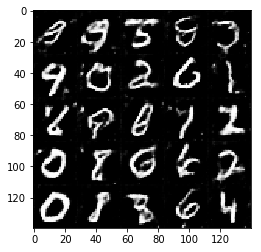

Epoch 2/2 ... Discriminator Loss: 1.0004 Generator Loss: 0.8877
Epoch 2/2 ... Discriminator Loss: 2.4562 Generator Loss: 0.1820
Epoch 2/2 ... Discriminator Loss: 1.0955 Generator Loss: 0.5922
Epoch 2/2 ... Discriminator Loss: 1.7980 Generator Loss: 3.1846
Epoch 2/2 ... Discriminator Loss: 1.1812 Generator Loss: 0.5906
Epoch 2/2 ... Discriminator Loss: 0.8856 Generator Loss: 0.8211
Epoch 2/2 ... Discriminator Loss: 2.0499 Generator Loss: 0.2628
Epoch 2/2 ... Discriminator Loss: 0.9921 Generator Loss: 0.8428
Epoch 2/2 ... Discriminator Loss: 1.3602 Generator Loss: 0.4285
Epoch 2/2 ... Discriminator Loss: 2.5431 Generator Loss: 0.1550


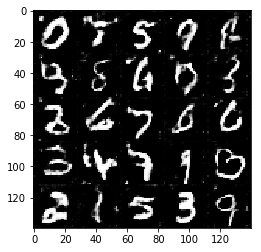

Epoch 2/2 ... Discriminator Loss: 1.9304 Generator Loss: 0.3361
Epoch 2/2 ... Discriminator Loss: 1.1879 Generator Loss: 0.5647
Epoch 2/2 ... Discriminator Loss: 1.2083 Generator Loss: 0.5180
Epoch 2/2 ... Discriminator Loss: 1.2965 Generator Loss: 1.9256
Epoch 2/2 ... Discriminator Loss: 0.9774 Generator Loss: 0.6588
Epoch 2/2 ... Discriminator Loss: 1.8790 Generator Loss: 0.2938
Epoch 2/2 ... Discriminator Loss: 1.5614 Generator Loss: 0.3636
Epoch 2/2 ... Discriminator Loss: 0.6899 Generator Loss: 1.0248
Epoch 2/2 ... Discriminator Loss: 1.0567 Generator Loss: 0.7265
Epoch 2/2 ... Discriminator Loss: 0.7181 Generator Loss: 1.0658


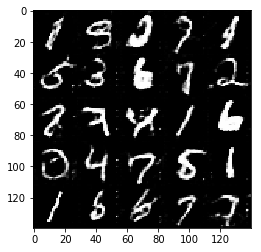

Epoch 2/2 ... Discriminator Loss: 0.5587 Generator Loss: 1.2173
Epoch 2/2 ... Discriminator Loss: 0.8711 Generator Loss: 0.8264
Epoch 2/2 ... Discriminator Loss: 0.5406 Generator Loss: 1.3103
Epoch 2/2 ... Discriminator Loss: 2.0951 Generator Loss: 0.2794
Epoch 2/2 ... Discriminator Loss: 0.7640 Generator Loss: 1.0970
Epoch 2/2 ... Discriminator Loss: 0.6079 Generator Loss: 1.1694
Epoch 2/2 ... Discriminator Loss: 1.3895 Generator Loss: 5.1598


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1 ... Discriminator Loss: 1.6224 Generator Loss: 7.2894
Epoch 1/1 ... Discriminator Loss: 0.5488 Generator Loss: 2.3891
Epoch 1/1 ... Discriminator Loss: 1.2216 Generator Loss: 4.0511
Epoch 1/1 ... Discriminator Loss: 0.8860 Generator Loss: 1.4274
Epoch 1/1 ... Discriminator Loss: 4.1125 Generator Loss: 0.0904
Epoch 1/1 ... Discriminator Loss: 0.2363 Generator Loss: 2.9317
Epoch 1/1 ... Discriminator Loss: 0.9884 Generator Loss: 1.5727
Epoch 1/1 ... Discriminator Loss: 0.2531 Generator Loss: 1.9902
Epoch 1/1 ... Discriminator Loss: 8.3419 Generator Loss: 0.0099
Epoch 1/1 ... Discriminator Loss: 1.5559 Generator Loss: 1.1932


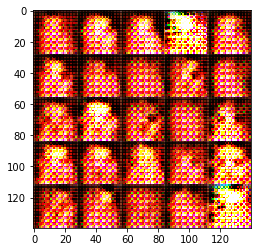

Epoch 1/1 ... Discriminator Loss: 1.0903 Generator Loss: 0.4433
Epoch 1/1 ... Discriminator Loss: 0.5453 Generator Loss: 1.7820
Epoch 1/1 ... Discriminator Loss: 0.1688 Generator Loss: 2.4764
Epoch 1/1 ... Discriminator Loss: 0.2588 Generator Loss: 4.1292
Epoch 1/1 ... Discriminator Loss: 1.8269 Generator Loss: 1.3773
Epoch 1/1 ... Discriminator Loss: 0.7392 Generator Loss: 2.8987
Epoch 1/1 ... Discriminator Loss: 0.0648 Generator Loss: 3.0988
Epoch 1/1 ... Discriminator Loss: 0.7911 Generator Loss: 0.7399
Epoch 1/1 ... Discriminator Loss: 10.8232 Generator Loss: 7.6794
Epoch 1/1 ... Discriminator Loss: 1.2438 Generator Loss: 1.3010


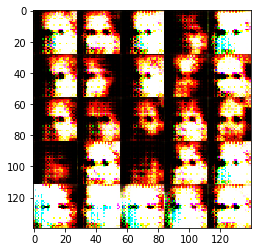

Epoch 1/1 ... Discriminator Loss: 0.8590 Generator Loss: 1.1225
Epoch 1/1 ... Discriminator Loss: 0.4668 Generator Loss: 1.8595
Epoch 1/1 ... Discriminator Loss: 0.5849 Generator Loss: 2.2535
Epoch 1/1 ... Discriminator Loss: 0.1369 Generator Loss: 2.4173
Epoch 1/1 ... Discriminator Loss: 0.3528 Generator Loss: 1.7259
Epoch 1/1 ... Discriminator Loss: 0.1335 Generator Loss: 2.8422
Epoch 1/1 ... Discriminator Loss: 0.0684 Generator Loss: 2.9987
Epoch 1/1 ... Discriminator Loss: 0.0747 Generator Loss: 3.0705
Epoch 1/1 ... Discriminator Loss: 0.1271 Generator Loss: 2.5210
Epoch 1/1 ... Discriminator Loss: 0.0302 Generator Loss: 3.8438


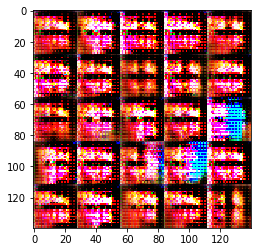

Epoch 1/1 ... Discriminator Loss: 0.0254 Generator Loss: 3.9173
Epoch 1/1 ... Discriminator Loss: 0.1223 Generator Loss: 2.9010
Epoch 1/1 ... Discriminator Loss: 0.0266 Generator Loss: 3.9146
Epoch 1/1 ... Discriminator Loss: 0.0783 Generator Loss: 3.6399
Epoch 1/1 ... Discriminator Loss: 0.0085 Generator Loss: 5.2950
Epoch 1/1 ... Discriminator Loss: 0.6011 Generator Loss: 0.9768
Epoch 1/1 ... Discriminator Loss: 1.8527 Generator Loss: 0.3387
Epoch 1/1 ... Discriminator Loss: 9.7471 Generator Loss: 11.1878
Epoch 1/1 ... Discriminator Loss: 1.6614 Generator Loss: 0.3031
Epoch 1/1 ... Discriminator Loss: 0.4501 Generator Loss: 1.3700


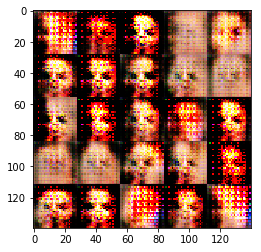

Epoch 1/1 ... Discriminator Loss: 0.1761 Generator Loss: 2.2267
Epoch 1/1 ... Discriminator Loss: 0.1680 Generator Loss: 2.4060
Epoch 1/1 ... Discriminator Loss: 0.9838 Generator Loss: 3.1921
Epoch 1/1 ... Discriminator Loss: 0.0278 Generator Loss: 4.7827
Epoch 1/1 ... Discriminator Loss: 0.1069 Generator Loss: 3.2635
Epoch 1/1 ... Discriminator Loss: 0.1617 Generator Loss: 2.2663
Epoch 1/1 ... Discriminator Loss: 0.2368 Generator Loss: 2.1018
Epoch 1/1 ... Discriminator Loss: 0.5100 Generator Loss: 1.2746
Epoch 1/1 ... Discriminator Loss: 0.0824 Generator Loss: 3.1133
Epoch 1/1 ... Discriminator Loss: 0.0181 Generator Loss: 4.5093


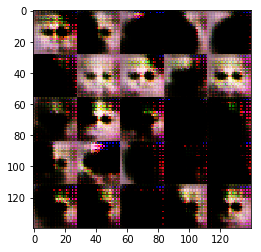

Epoch 1/1 ... Discriminator Loss: 0.2774 Generator Loss: 2.0330
Epoch 1/1 ... Discriminator Loss: 0.0284 Generator Loss: 3.7355
Epoch 1/1 ... Discriminator Loss: 0.0126 Generator Loss: 4.5118
Epoch 1/1 ... Discriminator Loss: 0.0137 Generator Loss: 4.4290
Epoch 1/1 ... Discriminator Loss: 0.0159 Generator Loss: 4.3669
Epoch 1/1 ... Discriminator Loss: 0.0116 Generator Loss: 4.7382
Epoch 1/1 ... Discriminator Loss: 0.0090 Generator Loss: 5.0037
Epoch 1/1 ... Discriminator Loss: 1.9328 Generator Loss: 0.2347
Epoch 1/1 ... Discriminator Loss: 0.0973 Generator Loss: 2.9637
Epoch 1/1 ... Discriminator Loss: 0.0864 Generator Loss: 3.0797


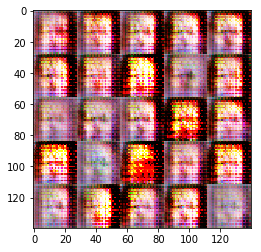

Epoch 1/1 ... Discriminator Loss: 0.0410 Generator Loss: 3.7900
Epoch 1/1 ... Discriminator Loss: 10.0925 Generator Loss: 10.5052
Epoch 1/1 ... Discriminator Loss: 1.5976 Generator Loss: 0.7039
Epoch 1/1 ... Discriminator Loss: 0.8840 Generator Loss: 0.8268
Epoch 1/1 ... Discriminator Loss: 0.0924 Generator Loss: 2.7883
Epoch 1/1 ... Discriminator Loss: 0.1594 Generator Loss: 2.2134
Epoch 1/1 ... Discriminator Loss: 0.0313 Generator Loss: 3.9778
Epoch 1/1 ... Discriminator Loss: 1.3209 Generator Loss: 1.2027
Epoch 1/1 ... Discriminator Loss: 0.3787 Generator Loss: 1.4158
Epoch 1/1 ... Discriminator Loss: 0.2726 Generator Loss: 3.3057


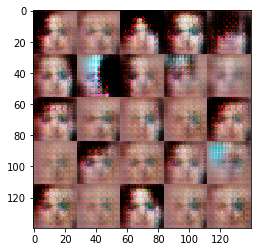

Epoch 1/1 ... Discriminator Loss: 0.7238 Generator Loss: 1.0595
Epoch 1/1 ... Discriminator Loss: 1.1216 Generator Loss: 3.3221
Epoch 1/1 ... Discriminator Loss: 1.9904 Generator Loss: 1.0735
Epoch 1/1 ... Discriminator Loss: 1.6686 Generator Loss: 2.1774
Epoch 1/1 ... Discriminator Loss: 0.7194 Generator Loss: 1.0845
Epoch 1/1 ... Discriminator Loss: 0.4618 Generator Loss: 1.2027
Epoch 1/1 ... Discriminator Loss: 0.9859 Generator Loss: 1.2838
Epoch 1/1 ... Discriminator Loss: 1.6937 Generator Loss: 2.8777
Epoch 1/1 ... Discriminator Loss: 1.1375 Generator Loss: 0.6293
Epoch 1/1 ... Discriminator Loss: 0.9207 Generator Loss: 0.7135


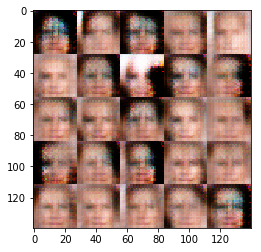

Epoch 1/1 ... Discriminator Loss: 1.3329 Generator Loss: 0.8038
Epoch 1/1 ... Discriminator Loss: 0.3691 Generator Loss: 2.3006
Epoch 1/1 ... Discriminator Loss: 1.0174 Generator Loss: 0.5412
Epoch 1/1 ... Discriminator Loss: 1.1418 Generator Loss: 1.4016
Epoch 1/1 ... Discriminator Loss: 1.3505 Generator Loss: 0.4165
Epoch 1/1 ... Discriminator Loss: 1.4128 Generator Loss: 1.5165
Epoch 1/1 ... Discriminator Loss: 1.4517 Generator Loss: 1.1750
Epoch 1/1 ... Discriminator Loss: 1.6568 Generator Loss: 1.8301
Epoch 1/1 ... Discriminator Loss: 2.0380 Generator Loss: 0.2176
Epoch 1/1 ... Discriminator Loss: 1.3841 Generator Loss: 0.4443


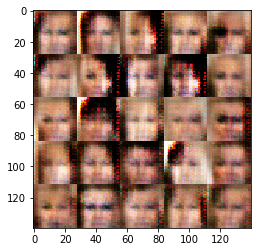

Epoch 1/1 ... Discriminator Loss: 1.2638 Generator Loss: 2.0251
Epoch 1/1 ... Discriminator Loss: 0.6447 Generator Loss: 0.9936
Epoch 1/1 ... Discriminator Loss: 1.0934 Generator Loss: 0.7950
Epoch 1/1 ... Discriminator Loss: 1.6461 Generator Loss: 0.2937
Epoch 1/1 ... Discriminator Loss: 1.2622 Generator Loss: 0.5042
Epoch 1/1 ... Discriminator Loss: 1.0734 Generator Loss: 0.5492
Epoch 1/1 ... Discriminator Loss: 1.2754 Generator Loss: 0.5151
Epoch 1/1 ... Discriminator Loss: 1.3603 Generator Loss: 0.4336
Epoch 1/1 ... Discriminator Loss: 0.5564 Generator Loss: 1.2486
Epoch 1/1 ... Discriminator Loss: 0.0892 Generator Loss: 2.7214


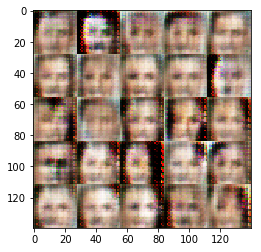

Epoch 1/1 ... Discriminator Loss: 1.5640 Generator Loss: 0.8281
Epoch 1/1 ... Discriminator Loss: 0.9264 Generator Loss: 1.0105
Epoch 1/1 ... Discriminator Loss: 0.3557 Generator Loss: 1.7822
Epoch 1/1 ... Discriminator Loss: 0.1902 Generator Loss: 1.9341
Epoch 1/1 ... Discriminator Loss: 0.4712 Generator Loss: 1.4897
Epoch 1/1 ... Discriminator Loss: 1.2093 Generator Loss: 0.8828
Epoch 1/1 ... Discriminator Loss: 1.0245 Generator Loss: 0.8281
Epoch 1/1 ... Discriminator Loss: 0.2908 Generator Loss: 1.5792
Epoch 1/1 ... Discriminator Loss: 2.8261 Generator Loss: 3.3143
Epoch 1/1 ... Discriminator Loss: 2.8359 Generator Loss: 0.1072


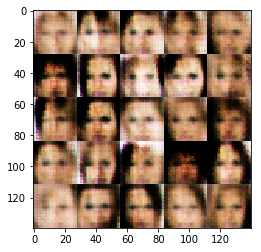

Epoch 1/1 ... Discriminator Loss: 1.1586 Generator Loss: 0.9962
Epoch 1/1 ... Discriminator Loss: 1.1712 Generator Loss: 1.0395
Epoch 1/1 ... Discriminator Loss: 0.8735 Generator Loss: 0.9609
Epoch 1/1 ... Discriminator Loss: 1.4701 Generator Loss: 0.5184
Epoch 1/1 ... Discriminator Loss: 1.0496 Generator Loss: 0.7502
Epoch 1/1 ... Discriminator Loss: 1.2919 Generator Loss: 0.6360
Epoch 1/1 ... Discriminator Loss: 1.3363 Generator Loss: 0.6666
Epoch 1/1 ... Discriminator Loss: 1.2257 Generator Loss: 0.6776
Epoch 1/1 ... Discriminator Loss: 1.3269 Generator Loss: 0.4269
Epoch 1/1 ... Discriminator Loss: 1.2107 Generator Loss: 0.5169


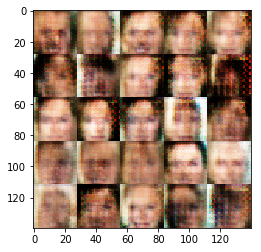

Epoch 1/1 ... Discriminator Loss: 1.0582 Generator Loss: 0.5636
Epoch 1/1 ... Discriminator Loss: 1.5281 Generator Loss: 1.1094
Epoch 1/1 ... Discriminator Loss: 1.6408 Generator Loss: 0.6134
Epoch 1/1 ... Discriminator Loss: 1.3242 Generator Loss: 0.6834
Epoch 1/1 ... Discriminator Loss: 1.5080 Generator Loss: 0.5910
Epoch 1/1 ... Discriminator Loss: 1.0141 Generator Loss: 0.7728
Epoch 1/1 ... Discriminator Loss: 1.4646 Generator Loss: 1.0326
Epoch 1/1 ... Discriminator Loss: 1.3373 Generator Loss: 1.1457
Epoch 1/1 ... Discriminator Loss: 1.3076 Generator Loss: 1.0636
Epoch 1/1 ... Discriminator Loss: 1.2495 Generator Loss: 0.5956


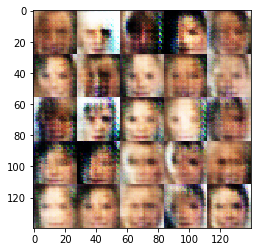

Epoch 1/1 ... Discriminator Loss: 1.5543 Generator Loss: 0.3940
Epoch 1/1 ... Discriminator Loss: 1.0548 Generator Loss: 1.2904
Epoch 1/1 ... Discriminator Loss: 1.5381 Generator Loss: 0.3887
Epoch 1/1 ... Discriminator Loss: 0.9627 Generator Loss: 0.7785
Epoch 1/1 ... Discriminator Loss: 1.5652 Generator Loss: 1.3231
Epoch 1/1 ... Discriminator Loss: 1.1232 Generator Loss: 1.0233
Epoch 1/1 ... Discriminator Loss: 1.2320 Generator Loss: 0.6544
Epoch 1/1 ... Discriminator Loss: 0.7826 Generator Loss: 0.8423
Epoch 1/1 ... Discriminator Loss: 0.5237 Generator Loss: 2.1310
Epoch 1/1 ... Discriminator Loss: 2.0853 Generator Loss: 0.2360


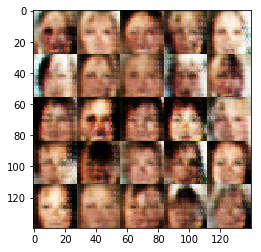

Epoch 1/1 ... Discriminator Loss: 1.1810 Generator Loss: 0.6639
Epoch 1/1 ... Discriminator Loss: 1.1726 Generator Loss: 0.7861
Epoch 1/1 ... Discriminator Loss: 1.1731 Generator Loss: 1.4402
Epoch 1/1 ... Discriminator Loss: 0.9693 Generator Loss: 0.6502
Epoch 1/1 ... Discriminator Loss: 1.2944 Generator Loss: 0.4400
Epoch 1/1 ... Discriminator Loss: 0.5142 Generator Loss: 1.0916
Epoch 1/1 ... Discriminator Loss: 0.1712 Generator Loss: 2.1233
Epoch 1/1 ... Discriminator Loss: 0.0657 Generator Loss: 3.1949
Epoch 1/1 ... Discriminator Loss: 0.1767 Generator Loss: 2.2271
Epoch 1/1 ... Discriminator Loss: 0.2437 Generator Loss: 1.8838


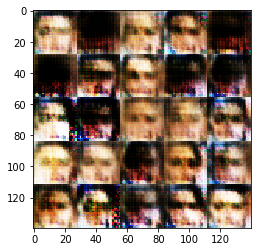

Epoch 1/1 ... Discriminator Loss: 0.5611 Generator Loss: 1.0890
Epoch 1/1 ... Discriminator Loss: 0.5153 Generator Loss: 1.0676
Epoch 1/1 ... Discriminator Loss: 1.1703 Generator Loss: 2.1312
Epoch 1/1 ... Discriminator Loss: 1.4163 Generator Loss: 0.5605
Epoch 1/1 ... Discriminator Loss: 2.7257 Generator Loss: 2.1684
Epoch 1/1 ... Discriminator Loss: 1.2972 Generator Loss: 0.6874
Epoch 1/1 ... Discriminator Loss: 1.0312 Generator Loss: 0.8950
Epoch 1/1 ... Discriminator Loss: 1.0634 Generator Loss: 1.0893
Epoch 1/1 ... Discriminator Loss: 1.1805 Generator Loss: 0.9627
Epoch 1/1 ... Discriminator Loss: 1.4452 Generator Loss: 0.3794


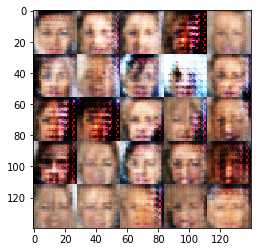

Epoch 1/1 ... Discriminator Loss: 0.6844 Generator Loss: 0.9828
Epoch 1/1 ... Discriminator Loss: 2.5298 Generator Loss: 2.8548
Epoch 1/1 ... Discriminator Loss: 1.1829 Generator Loss: 0.9371
Epoch 1/1 ... Discriminator Loss: 1.0992 Generator Loss: 0.6131
Epoch 1/1 ... Discriminator Loss: 0.1978 Generator Loss: 1.9810
Epoch 1/1 ... Discriminator Loss: 1.7717 Generator Loss: 0.3853
Epoch 1/1 ... Discriminator Loss: 1.1402 Generator Loss: 2.5986
Epoch 1/1 ... Discriminator Loss: 2.5051 Generator Loss: 0.3411
Epoch 1/1 ... Discriminator Loss: 0.8657 Generator Loss: 1.4352
Epoch 1/1 ... Discriminator Loss: 1.3854 Generator Loss: 1.6604


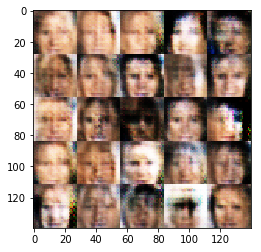

Epoch 1/1 ... Discriminator Loss: 1.1510 Generator Loss: 0.6917
Epoch 1/1 ... Discriminator Loss: 0.8475 Generator Loss: 0.6833
Epoch 1/1 ... Discriminator Loss: 0.9300 Generator Loss: 1.4070
Epoch 1/1 ... Discriminator Loss: 1.3172 Generator Loss: 0.7644
Epoch 1/1 ... Discriminator Loss: 1.2636 Generator Loss: 1.0939
Epoch 1/1 ... Discriminator Loss: 1.8892 Generator Loss: 2.2058
Epoch 1/1 ... Discriminator Loss: 2.2474 Generator Loss: 0.1680
Epoch 1/1 ... Discriminator Loss: 1.6446 Generator Loss: 0.4350
Epoch 1/1 ... Discriminator Loss: 1.3824 Generator Loss: 0.4123
Epoch 1/1 ... Discriminator Loss: 1.3483 Generator Loss: 2.0195


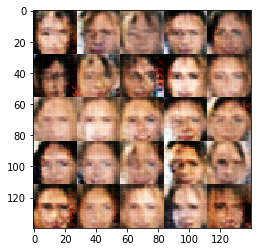

Epoch 1/1 ... Discriminator Loss: 1.0705 Generator Loss: 0.5319
Epoch 1/1 ... Discriminator Loss: 1.5015 Generator Loss: 0.9336
Epoch 1/1 ... Discriminator Loss: 0.3442 Generator Loss: 1.4679
Epoch 1/1 ... Discriminator Loss: 0.1069 Generator Loss: 2.4929
Epoch 1/1 ... Discriminator Loss: 0.0893 Generator Loss: 2.7273
Epoch 1/1 ... Discriminator Loss: 0.0643 Generator Loss: 2.9054
Epoch 1/1 ... Discriminator Loss: 1.0207 Generator Loss: 2.9740
Epoch 1/1 ... Discriminator Loss: 1.6710 Generator Loss: 0.2980
Epoch 1/1 ... Discriminator Loss: 1.1309 Generator Loss: 0.6377
Epoch 1/1 ... Discriminator Loss: 1.1941 Generator Loss: 1.3822


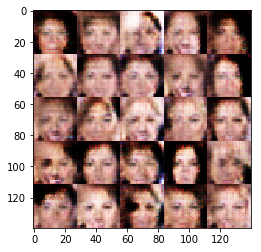

Epoch 1/1 ... Discriminator Loss: 0.6777 Generator Loss: 1.2607
Epoch 1/1 ... Discriminator Loss: 0.2146 Generator Loss: 1.9733
Epoch 1/1 ... Discriminator Loss: 0.1523 Generator Loss: 3.2667
Epoch 1/1 ... Discriminator Loss: 0.0099 Generator Loss: 6.8269
Epoch 1/1 ... Discriminator Loss: 0.0581 Generator Loss: 3.0876
Epoch 1/1 ... Discriminator Loss: 0.7845 Generator Loss: 1.3846
Epoch 1/1 ... Discriminator Loss: 0.4974 Generator Loss: 1.9046
Epoch 1/1 ... Discriminator Loss: 0.4934 Generator Loss: 1.0262
Epoch 1/1 ... Discriminator Loss: 1.3007 Generator Loss: 0.8076
Epoch 1/1 ... Discriminator Loss: 1.5070 Generator Loss: 0.5114


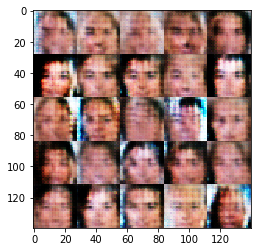

Epoch 1/1 ... Discriminator Loss: 0.1588 Generator Loss: 2.1794
Epoch 1/1 ... Discriminator Loss: 1.8686 Generator Loss: 2.4687
Epoch 1/1 ... Discriminator Loss: 1.0367 Generator Loss: 0.8000
Epoch 1/1 ... Discriminator Loss: 0.7409 Generator Loss: 0.8471
Epoch 1/1 ... Discriminator Loss: 0.0329 Generator Loss: 4.3026
Epoch 1/1 ... Discriminator Loss: 0.0937 Generator Loss: 2.6870
Epoch 1/1 ... Discriminator Loss: 0.1808 Generator Loss: 1.9946
Epoch 1/1 ... Discriminator Loss: 0.0389 Generator Loss: 3.6239
Epoch 1/1 ... Discriminator Loss: 0.0313 Generator Loss: 3.8297
Epoch 1/1 ... Discriminator Loss: 0.0244 Generator Loss: 3.8704


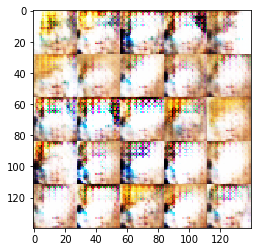

Epoch 1/1 ... Discriminator Loss: 0.0259 Generator Loss: 3.7789
Epoch 1/1 ... Discriminator Loss: 0.0354 Generator Loss: 3.4339
Epoch 1/1 ... Discriminator Loss: 0.9053 Generator Loss: 1.3203
Epoch 1/1 ... Discriminator Loss: 1.1920 Generator Loss: 1.0718
Epoch 1/1 ... Discriminator Loss: 0.9053 Generator Loss: 1.2126
Epoch 1/1 ... Discriminator Loss: 1.2060 Generator Loss: 0.9600
Epoch 1/1 ... Discriminator Loss: 1.5071 Generator Loss: 1.2015
Epoch 1/1 ... Discriminator Loss: 0.8352 Generator Loss: 0.9398
Epoch 1/1 ... Discriminator Loss: 2.0223 Generator Loss: 0.2272
Epoch 1/1 ... Discriminator Loss: 1.2361 Generator Loss: 0.4273


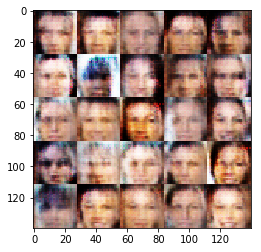

Epoch 1/1 ... Discriminator Loss: 1.2154 Generator Loss: 0.9983
Epoch 1/1 ... Discriminator Loss: 1.2785 Generator Loss: 0.5470
Epoch 1/1 ... Discriminator Loss: 1.0035 Generator Loss: 1.2398
Epoch 1/1 ... Discriminator Loss: 1.6912 Generator Loss: 0.2487
Epoch 1/1 ... Discriminator Loss: 1.0585 Generator Loss: 0.6073
Epoch 1/1 ... Discriminator Loss: 1.4315 Generator Loss: 0.3985
Epoch 1/1 ... Discriminator Loss: 1.5315 Generator Loss: 0.4621
Epoch 1/1 ... Discriminator Loss: 1.3343 Generator Loss: 0.7100
Epoch 1/1 ... Discriminator Loss: 1.4162 Generator Loss: 0.4534
Epoch 1/1 ... Discriminator Loss: 1.2518 Generator Loss: 0.8323


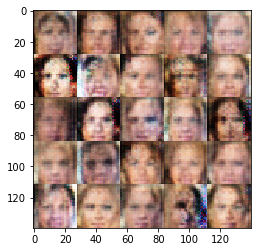

Epoch 1/1 ... Discriminator Loss: 1.2447 Generator Loss: 0.7290
Epoch 1/1 ... Discriminator Loss: 1.2829 Generator Loss: 0.5471
Epoch 1/1 ... Discriminator Loss: 1.1828 Generator Loss: 0.6135
Epoch 1/1 ... Discriminator Loss: 1.3222 Generator Loss: 0.5636
Epoch 1/1 ... Discriminator Loss: 1.2703 Generator Loss: 0.5290
Epoch 1/1 ... Discriminator Loss: 1.1615 Generator Loss: 0.6121
Epoch 1/1 ... Discriminator Loss: 2.3980 Generator Loss: 0.1981
Epoch 1/1 ... Discriminator Loss: 1.3140 Generator Loss: 0.6945
Epoch 1/1 ... Discriminator Loss: 2.3505 Generator Loss: 0.1332
Epoch 1/1 ... Discriminator Loss: 1.2787 Generator Loss: 0.7812


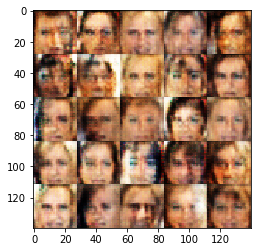

Epoch 1/1 ... Discriminator Loss: 1.0739 Generator Loss: 0.8081
Epoch 1/1 ... Discriminator Loss: 1.0706 Generator Loss: 0.8260
Epoch 1/1 ... Discriminator Loss: 0.8374 Generator Loss: 0.9920
Epoch 1/1 ... Discriminator Loss: 0.6956 Generator Loss: 0.9020
Epoch 1/1 ... Discriminator Loss: 1.7559 Generator Loss: 2.0081
Epoch 1/1 ... Discriminator Loss: 1.3179 Generator Loss: 0.4521
Epoch 1/1 ... Discriminator Loss: 1.4724 Generator Loss: 0.4265
Epoch 1/1 ... Discriminator Loss: 0.5207 Generator Loss: 1.1643
Epoch 1/1 ... Discriminator Loss: 0.6578 Generator Loss: 1.0221
Epoch 1/1 ... Discriminator Loss: 0.1187 Generator Loss: 2.3572


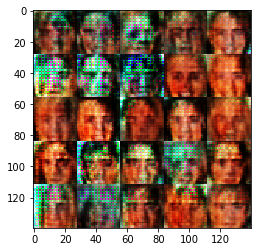

Epoch 1/1 ... Discriminator Loss: 0.0669 Generator Loss: 2.9357
Epoch 1/1 ... Discriminator Loss: 0.0349 Generator Loss: 3.6397
Epoch 1/1 ... Discriminator Loss: 0.0245 Generator Loss: 3.9399
Epoch 1/1 ... Discriminator Loss: 0.0238 Generator Loss: 3.8282
Epoch 1/1 ... Discriminator Loss: 0.0198 Generator Loss: 4.1974
Epoch 1/1 ... Discriminator Loss: 0.0177 Generator Loss: 4.4295
Epoch 1/1 ... Discriminator Loss: 0.0187 Generator Loss: 4.4483
Epoch 1/1 ... Discriminator Loss: 0.0173 Generator Loss: 4.1596
Epoch 1/1 ... Discriminator Loss: 0.0038 Generator Loss: 5.7603
Epoch 1/1 ... Discriminator Loss: 0.0284 Generator Loss: 3.9636


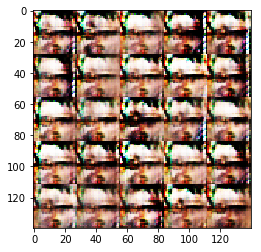

Epoch 1/1 ... Discriminator Loss: 0.0040 Generator Loss: 5.9836
Epoch 1/1 ... Discriminator Loss: 0.0059 Generator Loss: 5.6038
Epoch 1/1 ... Discriminator Loss: 0.3010 Generator Loss: 6.8793
Epoch 1/1 ... Discriminator Loss: 1.1341 Generator Loss: 0.6835
Epoch 1/1 ... Discriminator Loss: 1.0957 Generator Loss: 4.0884
Epoch 1/1 ... Discriminator Loss: 1.0099 Generator Loss: 0.9277
Epoch 1/1 ... Discriminator Loss: 0.8224 Generator Loss: 0.9614
Epoch 1/1 ... Discriminator Loss: 0.9691 Generator Loss: 0.8310
Epoch 1/1 ... Discriminator Loss: 0.8646 Generator Loss: 1.2984
Epoch 1/1 ... Discriminator Loss: 1.3387 Generator Loss: 0.5935


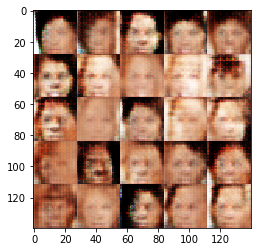

Epoch 1/1 ... Discriminator Loss: 0.1651 Generator Loss: 2.1066
Epoch 1/1 ... Discriminator Loss: 0.2077 Generator Loss: 1.7867
Epoch 1/1 ... Discriminator Loss: 0.4694 Generator Loss: 2.1304
Epoch 1/1 ... Discriminator Loss: 0.4180 Generator Loss: 1.4623
Epoch 1/1 ... Discriminator Loss: 2.1143 Generator Loss: 0.1832
Epoch 1/1 ... Discriminator Loss: 0.4138 Generator Loss: 1.7580
Epoch 1/1 ... Discriminator Loss: 0.7149 Generator Loss: 1.4711
Epoch 1/1 ... Discriminator Loss: 1.5898 Generator Loss: 1.3970
Epoch 1/1 ... Discriminator Loss: 1.2165 Generator Loss: 0.8393
Epoch 1/1 ... Discriminator Loss: 1.0118 Generator Loss: 0.8711


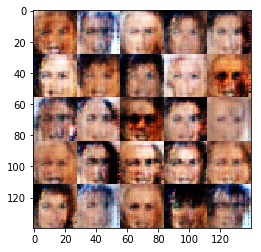

Epoch 1/1 ... Discriminator Loss: 1.1039 Generator Loss: 0.9116
Epoch 1/1 ... Discriminator Loss: 0.6993 Generator Loss: 2.0703
Epoch 1/1 ... Discriminator Loss: 0.3583 Generator Loss: 1.3612
Epoch 1/1 ... Discriminator Loss: 0.0474 Generator Loss: 3.2369
Epoch 1/1 ... Discriminator Loss: 0.0545 Generator Loss: 3.2521
Epoch 1/1 ... Discriminator Loss: 0.0216 Generator Loss: 4.1344
Epoch 1/1 ... Discriminator Loss: 0.0041 Generator Loss: 6.6845
Epoch 1/1 ... Discriminator Loss: 0.0128 Generator Loss: 5.5831
Epoch 1/1 ... Discriminator Loss: 0.0516 Generator Loss: 3.1550
Epoch 1/1 ... Discriminator Loss: 0.0069 Generator Loss: 5.3444


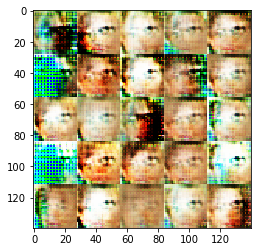

Epoch 1/1 ... Discriminator Loss: 0.0219 Generator Loss: 4.0927
Epoch 1/1 ... Discriminator Loss: 0.0101 Generator Loss: 5.4136
Epoch 1/1 ... Discriminator Loss: 0.0031 Generator Loss: 6.2873
Epoch 1/1 ... Discriminator Loss: 0.0069 Generator Loss: 5.2739
Epoch 1/1 ... Discriminator Loss: 0.0581 Generator Loss: 3.0128
Epoch 1/1 ... Discriminator Loss: 0.9426 Generator Loss: 1.1722
Epoch 1/1 ... Discriminator Loss: 0.8880 Generator Loss: 0.6561
Epoch 1/1 ... Discriminator Loss: 1.9610 Generator Loss: 2.7698
Epoch 1/1 ... Discriminator Loss: 0.9017 Generator Loss: 0.6379
Epoch 1/1 ... Discriminator Loss: 0.1181 Generator Loss: 2.3687


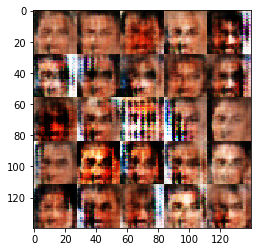

Epoch 1/1 ... Discriminator Loss: 0.0651 Generator Loss: 2.9142
Epoch 1/1 ... Discriminator Loss: 0.0364 Generator Loss: 3.5521
Epoch 1/1 ... Discriminator Loss: 1.1329 Generator Loss: 0.4652
Epoch 1/1 ... Discriminator Loss: 0.4573 Generator Loss: 1.1144
Epoch 1/1 ... Discriminator Loss: 0.0326 Generator Loss: 3.9175
Epoch 1/1 ... Discriminator Loss: 2.0772 Generator Loss: 3.9028
Epoch 1/1 ... Discriminator Loss: 0.9576 Generator Loss: 1.9184
Epoch 1/1 ... Discriminator Loss: 1.4946 Generator Loss: 0.3939
Epoch 1/1 ... Discriminator Loss: 0.2316 Generator Loss: 2.4176
Epoch 1/1 ... Discriminator Loss: 0.9773 Generator Loss: 0.8094


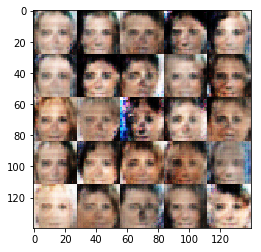

Epoch 1/1 ... Discriminator Loss: 1.2801 Generator Loss: 0.7486
Epoch 1/1 ... Discriminator Loss: 1.0739 Generator Loss: 0.8250
Epoch 1/1 ... Discriminator Loss: 1.1059 Generator Loss: 0.8818
Epoch 1/1 ... Discriminator Loss: 1.1939 Generator Loss: 0.6952
Epoch 1/1 ... Discriminator Loss: 1.0674 Generator Loss: 0.9906
Epoch 1/1 ... Discriminator Loss: 1.1785 Generator Loss: 0.6198
Epoch 1/1 ... Discriminator Loss: 0.8056 Generator Loss: 1.0081
Epoch 1/1 ... Discriminator Loss: 0.2568 Generator Loss: 2.1024
Epoch 1/1 ... Discriminator Loss: 1.2996 Generator Loss: 0.6060
Epoch 1/1 ... Discriminator Loss: 1.3327 Generator Loss: 0.7165


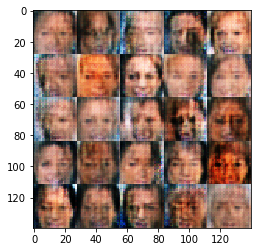

Epoch 1/1 ... Discriminator Loss: 1.1380 Generator Loss: 0.7070
Epoch 1/1 ... Discriminator Loss: 1.1596 Generator Loss: 0.6099
Epoch 1/1 ... Discriminator Loss: 1.0045 Generator Loss: 0.7460
Epoch 1/1 ... Discriminator Loss: 1.1197 Generator Loss: 1.0190
Epoch 1/1 ... Discriminator Loss: 1.2292 Generator Loss: 0.7291
Epoch 1/1 ... Discriminator Loss: 1.0533 Generator Loss: 0.9735
Epoch 1/1 ... Discriminator Loss: 1.5515 Generator Loss: 1.9103
Epoch 1/1 ... Discriminator Loss: 1.0117 Generator Loss: 0.9178
Epoch 1/1 ... Discriminator Loss: 1.4079 Generator Loss: 0.5081
Epoch 1/1 ... Discriminator Loss: 0.7326 Generator Loss: 0.9556


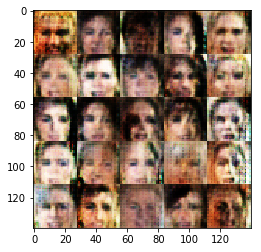

Epoch 1/1 ... Discriminator Loss: 0.8519 Generator Loss: 0.8261
Epoch 1/1 ... Discriminator Loss: 0.2035 Generator Loss: 1.9113
Epoch 1/1 ... Discriminator Loss: 0.0556 Generator Loss: 3.0587
Epoch 1/1 ... Discriminator Loss: 0.0271 Generator Loss: 3.8639
Epoch 1/1 ... Discriminator Loss: 0.0137 Generator Loss: 5.3512
Epoch 1/1 ... Discriminator Loss: 0.0225 Generator Loss: 4.0461
Epoch 1/1 ... Discriminator Loss: 0.0061 Generator Loss: 5.8502
Epoch 1/1 ... Discriminator Loss: 0.3235 Generator Loss: 1.7718
Epoch 1/1 ... Discriminator Loss: 0.0089 Generator Loss: 7.2001
Epoch 1/1 ... Discriminator Loss: 0.0036 Generator Loss: 7.6178


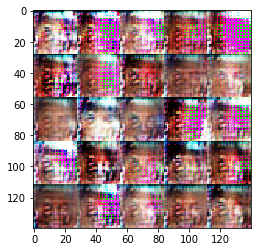

Epoch 1/1 ... Discriminator Loss: 0.0055 Generator Loss: 9.0753
Epoch 1/1 ... Discriminator Loss: 0.0005 Generator Loss: 9.0914
Epoch 1/1 ... Discriminator Loss: 0.0012 Generator Loss: 10.8770
Epoch 1/1 ... Discriminator Loss: 0.0015 Generator Loss: 6.7003
Epoch 1/1 ... Discriminator Loss: 17.1084 Generator Loss: 26.7483
Epoch 1/1 ... Discriminator Loss: 1.3331 Generator Loss: 0.6098
Epoch 1/1 ... Discriminator Loss: 0.8495 Generator Loss: 0.8548
Epoch 1/1 ... Discriminator Loss: 0.1552 Generator Loss: 2.1505
Epoch 1/1 ... Discriminator Loss: 0.0143 Generator Loss: 6.0324
Epoch 1/1 ... Discriminator Loss: 0.3586 Generator Loss: 2.9692


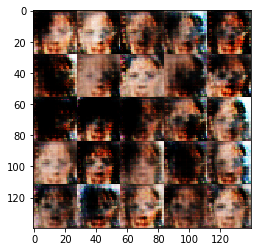

Epoch 1/1 ... Discriminator Loss: 1.2032 Generator Loss: 0.8985
Epoch 1/1 ... Discriminator Loss: 1.0482 Generator Loss: 0.5942
Epoch 1/1 ... Discriminator Loss: 1.0566 Generator Loss: 1.9042
Epoch 1/1 ... Discriminator Loss: 0.8661 Generator Loss: 1.1054
Epoch 1/1 ... Discriminator Loss: 1.2429 Generator Loss: 0.5693
Epoch 1/1 ... Discriminator Loss: 0.9884 Generator Loss: 0.7117
Epoch 1/1 ... Discriminator Loss: 1.0393 Generator Loss: 1.5182
Epoch 1/1 ... Discriminator Loss: 1.2759 Generator Loss: 0.7700
Epoch 1/1 ... Discriminator Loss: 1.1457 Generator Loss: 0.7401
Epoch 1/1 ... Discriminator Loss: 1.4325 Generator Loss: 0.6200


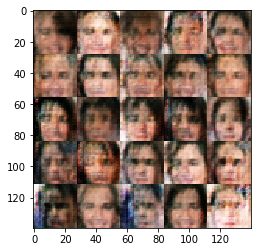

Epoch 1/1 ... Discriminator Loss: 1.1134 Generator Loss: 1.0541
Epoch 1/1 ... Discriminator Loss: 1.2126 Generator Loss: 0.5527
Epoch 1/1 ... Discriminator Loss: 0.1905 Generator Loss: 2.1566
Epoch 1/1 ... Discriminator Loss: 1.8327 Generator Loss: 0.2237
Epoch 1/1 ... Discriminator Loss: 1.4909 Generator Loss: 0.3685
Epoch 1/1 ... Discriminator Loss: 0.3530 Generator Loss: 1.3737
Epoch 1/1 ... Discriminator Loss: 0.3205 Generator Loss: 1.5687
Epoch 1/1 ... Discriminator Loss: 1.2756 Generator Loss: 0.4410
Epoch 1/1 ... Discriminator Loss: 0.0617 Generator Loss: 5.7242
Epoch 1/1 ... Discriminator Loss: 0.1095 Generator Loss: 2.4510


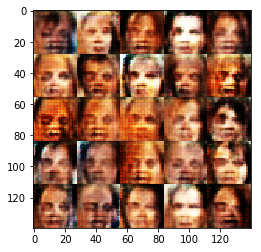

Epoch 1/1 ... Discriminator Loss: 0.0670 Generator Loss: 2.9023
Epoch 1/1 ... Discriminator Loss: 0.1677 Generator Loss: 2.0957
Epoch 1/1 ... Discriminator Loss: 0.0300 Generator Loss: 4.2296
Epoch 1/1 ... Discriminator Loss: 0.0212 Generator Loss: 4.0548
Epoch 1/1 ... Discriminator Loss: 0.0271 Generator Loss: 3.7460
Epoch 1/1 ... Discriminator Loss: 0.0012 Generator Loss: 7.2310
Epoch 1/1 ... Discriminator Loss: 0.0083 Generator Loss: 5.2050
Epoch 1/1 ... Discriminator Loss: 0.0026 Generator Loss: 6.9111
Epoch 1/1 ... Discriminator Loss: 0.0027 Generator Loss: 6.2670
Epoch 1/1 ... Discriminator Loss: 0.0061 Generator Loss: 5.7309


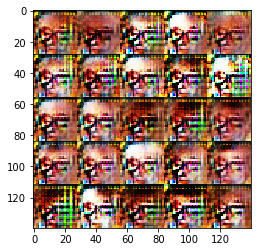

Epoch 1/1 ... Discriminator Loss: 0.0009 Generator Loss: 8.2414
Epoch 1/1 ... Discriminator Loss: 0.0076 Generator Loss: 5.0210
Epoch 1/1 ... Discriminator Loss: 0.0194 Generator Loss: 4.2851
Epoch 1/1 ... Discriminator Loss: 0.0034 Generator Loss: 6.5858
Epoch 1/1 ... Discriminator Loss: 0.0039 Generator Loss: 11.6932
Epoch 1/1 ... Discriminator Loss: 0.0015 Generator Loss: 7.7330
Epoch 1/1 ... Discriminator Loss: 0.0010 Generator Loss: 8.6896
Epoch 1/1 ... Discriminator Loss: 0.0015 Generator Loss: 7.0942
Epoch 1/1 ... Discriminator Loss: 0.0001 Generator Loss: 9.8196
Epoch 1/1 ... Discriminator Loss: 0.0027 Generator Loss: 6.6995


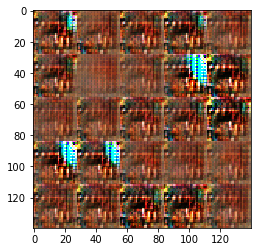

Epoch 1/1 ... Discriminator Loss: 0.0017 Generator Loss: 10.6365
Epoch 1/1 ... Discriminator Loss: 0.0001 Generator Loss: 10.8166
Epoch 1/1 ... Discriminator Loss: 0.0018 Generator Loss: 12.9967
Epoch 1/1 ... Discriminator Loss: 0.0010 Generator Loss: 7.3123
Epoch 1/1 ... Discriminator Loss: 0.0012 Generator Loss: 8.3166
Epoch 1/1 ... Discriminator Loss: 0.0069 Generator Loss: 6.1981
Epoch 1/1 ... Discriminator Loss: 0.0002 Generator Loss: 11.7146
Epoch 1/1 ... Discriminator Loss: 0.0007 Generator Loss: 9.5084
Epoch 1/1 ... Discriminator Loss: 0.0003 Generator Loss: 11.3419
Epoch 1/1 ... Discriminator Loss: 0.0013 Generator Loss: 6.9522


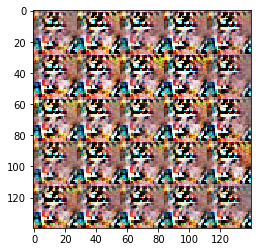

Epoch 1/1 ... Discriminator Loss: 0.0008 Generator Loss: 13.1310
Epoch 1/1 ... Discriminator Loss: 0.0001 Generator Loss: 11.4122
Epoch 1/1 ... Discriminator Loss: 0.0003 Generator Loss: 8.9692
Epoch 1/1 ... Discriminator Loss: 0.0008 Generator Loss: 12.9711
Epoch 1/1 ... Discriminator Loss: 0.0001 Generator Loss: 15.6072
Epoch 1/1 ... Discriminator Loss: 0.0000 Generator Loss: 14.0296
Epoch 1/1 ... Discriminator Loss: 0.6536 Generator Loss: 13.0576
Epoch 1/1 ... Discriminator Loss: 0.1825 Generator Loss: 3.5315
Epoch 1/1 ... Discriminator Loss: 0.3697 Generator Loss: 1.4537
Epoch 1/1 ... Discriminator Loss: 1.3168 Generator Loss: 0.6225


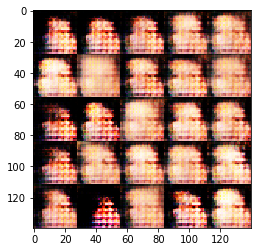

Epoch 1/1 ... Discriminator Loss: 1.0070 Generator Loss: 1.0398
Epoch 1/1 ... Discriminator Loss: 1.3181 Generator Loss: 0.6775
Epoch 1/1 ... Discriminator Loss: 0.9657 Generator Loss: 0.8152
Epoch 1/1 ... Discriminator Loss: 0.7048 Generator Loss: 2.0981
Epoch 1/1 ... Discriminator Loss: 2.1033 Generator Loss: 2.9518
Epoch 1/1 ... Discriminator Loss: 0.9372 Generator Loss: 1.0288
Epoch 1/1 ... Discriminator Loss: 1.6702 Generator Loss: 0.4488
Epoch 1/1 ... Discriminator Loss: 0.9392 Generator Loss: 1.8649
Epoch 1/1 ... Discriminator Loss: 1.4995 Generator Loss: 0.5531
Epoch 1/1 ... Discriminator Loss: 0.8281 Generator Loss: 1.2400


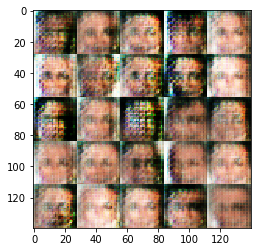

Epoch 1/1 ... Discriminator Loss: 1.3900 Generator Loss: 1.9894
Epoch 1/1 ... Discriminator Loss: 0.9311 Generator Loss: 1.0262
Epoch 1/1 ... Discriminator Loss: 0.9831 Generator Loss: 0.9630
Epoch 1/1 ... Discriminator Loss: 1.4058 Generator Loss: 0.4590
Epoch 1/1 ... Discriminator Loss: 1.0920 Generator Loss: 0.6977
Epoch 1/1 ... Discriminator Loss: 1.2780 Generator Loss: 0.8366
Epoch 1/1 ... Discriminator Loss: 1.2491 Generator Loss: 1.0088
Epoch 1/1 ... Discriminator Loss: 1.2133 Generator Loss: 0.7658
Epoch 1/1 ... Discriminator Loss: 1.2577 Generator Loss: 0.5858
Epoch 1/1 ... Discriminator Loss: 1.4411 Generator Loss: 0.3742


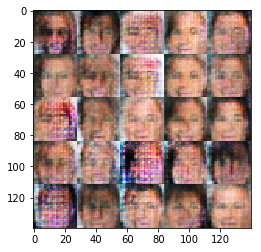

Epoch 1/1 ... Discriminator Loss: 1.1124 Generator Loss: 0.6981
Epoch 1/1 ... Discriminator Loss: 1.0616 Generator Loss: 0.8212
Epoch 1/1 ... Discriminator Loss: 1.9291 Generator Loss: 0.2263
Epoch 1/1 ... Discriminator Loss: 1.2853 Generator Loss: 0.8436
Epoch 1/1 ... Discriminator Loss: 1.6244 Generator Loss: 0.4262
Epoch 1/1 ... Discriminator Loss: 1.8400 Generator Loss: 0.3026
Epoch 1/1 ... Discriminator Loss: 1.1588 Generator Loss: 0.6524
Epoch 1/1 ... Discriminator Loss: 1.3154 Generator Loss: 0.5806
Epoch 1/1 ... Discriminator Loss: 1.3040 Generator Loss: 0.5108
Epoch 1/1 ... Discriminator Loss: 1.2881 Generator Loss: 0.7377


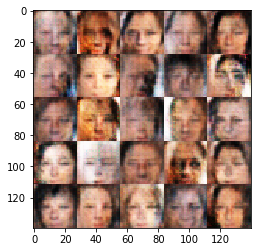

Epoch 1/1 ... Discriminator Loss: 1.1842 Generator Loss: 1.1861
Epoch 1/1 ... Discriminator Loss: 1.2349 Generator Loss: 0.8228
Epoch 1/1 ... Discriminator Loss: 1.2058 Generator Loss: 1.1766
Epoch 1/1 ... Discriminator Loss: 1.1532 Generator Loss: 0.7933
Epoch 1/1 ... Discriminator Loss: 1.3605 Generator Loss: 1.0206
Epoch 1/1 ... Discriminator Loss: 1.2762 Generator Loss: 0.6254
Epoch 1/1 ... Discriminator Loss: 1.3995 Generator Loss: 0.4386
Epoch 1/1 ... Discriminator Loss: 1.2865 Generator Loss: 0.5266
Epoch 1/1 ... Discriminator Loss: 1.2578 Generator Loss: 0.6511
Epoch 1/1 ... Discriminator Loss: 1.0853 Generator Loss: 1.3939


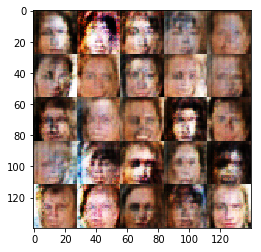

Epoch 1/1 ... Discriminator Loss: 1.0578 Generator Loss: 1.0295
Epoch 1/1 ... Discriminator Loss: 1.0780 Generator Loss: 0.8618
Epoch 1/1 ... Discriminator Loss: 1.0482 Generator Loss: 0.9987
Epoch 1/1 ... Discriminator Loss: 1.1644 Generator Loss: 0.6475
Epoch 1/1 ... Discriminator Loss: 1.0342 Generator Loss: 1.0385
Epoch 1/1 ... Discriminator Loss: 1.3848 Generator Loss: 1.1487
Epoch 1/1 ... Discriminator Loss: 1.5115 Generator Loss: 0.3600
Epoch 1/1 ... Discriminator Loss: 1.1621 Generator Loss: 1.0430
Epoch 1/1 ... Discriminator Loss: 1.3810 Generator Loss: 0.4932
Epoch 1/1 ... Discriminator Loss: 1.2418 Generator Loss: 1.4667


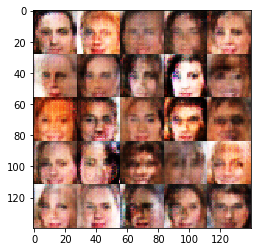

Epoch 1/1 ... Discriminator Loss: 1.1153 Generator Loss: 0.7502
Epoch 1/1 ... Discriminator Loss: 1.2800 Generator Loss: 0.7095
Epoch 1/1 ... Discriminator Loss: 1.4271 Generator Loss: 0.5274
Epoch 1/1 ... Discriminator Loss: 1.0685 Generator Loss: 0.8675
Epoch 1/1 ... Discriminator Loss: 1.0059 Generator Loss: 0.8854
Epoch 1/1 ... Discriminator Loss: 1.8198 Generator Loss: 0.2902
Epoch 1/1 ... Discriminator Loss: 1.5856 Generator Loss: 0.3713
Epoch 1/1 ... Discriminator Loss: 1.1042 Generator Loss: 0.6106
Epoch 1/1 ... Discriminator Loss: 1.2844 Generator Loss: 0.8007
Epoch 1/1 ... Discriminator Loss: 1.3791 Generator Loss: 0.5464


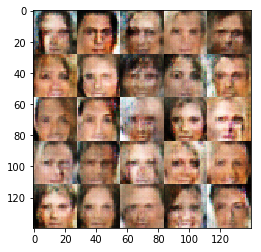

Epoch 1/1 ... Discriminator Loss: 1.4009 Generator Loss: 0.4899
Epoch 1/1 ... Discriminator Loss: 1.6829 Generator Loss: 0.3154
Epoch 1/1 ... Discriminator Loss: 1.1600 Generator Loss: 0.5553
Epoch 1/1 ... Discriminator Loss: 1.3693 Generator Loss: 0.4346
Epoch 1/1 ... Discriminator Loss: 1.0997 Generator Loss: 0.8256
Epoch 1/1 ... Discriminator Loss: 1.0575 Generator Loss: 0.7071
Epoch 1/1 ... Discriminator Loss: 1.1464 Generator Loss: 0.8035
Epoch 1/1 ... Discriminator Loss: 1.3769 Generator Loss: 0.3744
Epoch 1/1 ... Discriminator Loss: 1.5685 Generator Loss: 0.4151
Epoch 1/1 ... Discriminator Loss: 1.1514 Generator Loss: 0.6653


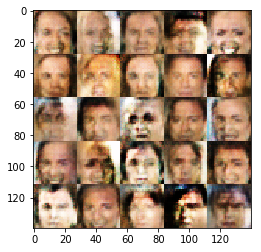

Epoch 1/1 ... Discriminator Loss: 1.3344 Generator Loss: 0.5339
Epoch 1/1 ... Discriminator Loss: 1.4220 Generator Loss: 0.4789
Epoch 1/1 ... Discriminator Loss: 1.3898 Generator Loss: 0.4314
Epoch 1/1 ... Discriminator Loss: 1.6294 Generator Loss: 0.3194
Epoch 1/1 ... Discriminator Loss: 1.2416 Generator Loss: 0.8688
Epoch 1/1 ... Discriminator Loss: 1.4914 Generator Loss: 0.3592
Epoch 1/1 ... Discriminator Loss: 1.5019 Generator Loss: 0.4640
Epoch 1/1 ... Discriminator Loss: 1.2184 Generator Loss: 0.6755
Epoch 1/1 ... Discriminator Loss: 1.3330 Generator Loss: 0.7601
Epoch 1/1 ... Discriminator Loss: 1.2699 Generator Loss: 0.5787


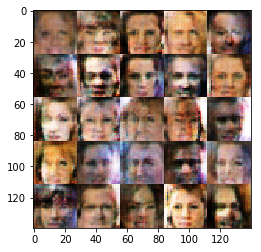

Epoch 1/1 ... Discriminator Loss: 1.3474 Generator Loss: 1.3790
Epoch 1/1 ... Discriminator Loss: 1.1998 Generator Loss: 0.6796
Epoch 1/1 ... Discriminator Loss: 1.0842 Generator Loss: 0.9124
Epoch 1/1 ... Discriminator Loss: 1.0964 Generator Loss: 0.8658
Epoch 1/1 ... Discriminator Loss: 1.1786 Generator Loss: 0.5588
Epoch 1/1 ... Discriminator Loss: 1.2233 Generator Loss: 0.9140
Epoch 1/1 ... Discriminator Loss: 1.3284 Generator Loss: 0.5334
Epoch 1/1 ... Discriminator Loss: 1.7655 Generator Loss: 2.1006
Epoch 1/1 ... Discriminator Loss: 1.2277 Generator Loss: 1.2319
Epoch 1/1 ... Discriminator Loss: 1.1104 Generator Loss: 0.8327


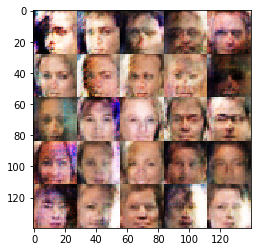

Epoch 1/1 ... Discriminator Loss: 1.5171 Generator Loss: 0.4434
Epoch 1/1 ... Discriminator Loss: 1.3902 Generator Loss: 0.3757
Epoch 1/1 ... Discriminator Loss: 1.7281 Generator Loss: 0.2859
Epoch 1/1 ... Discriminator Loss: 1.2310 Generator Loss: 0.7524
Epoch 1/1 ... Discriminator Loss: 1.1168 Generator Loss: 0.7192
Epoch 1/1 ... Discriminator Loss: 1.2945 Generator Loss: 0.7742
Epoch 1/1 ... Discriminator Loss: 1.0677 Generator Loss: 0.6514
Epoch 1/1 ... Discriminator Loss: 1.3627 Generator Loss: 0.4779
Epoch 1/1 ... Discriminator Loss: 1.4777 Generator Loss: 0.3693
Epoch 1/1 ... Discriminator Loss: 1.3585 Generator Loss: 0.4637


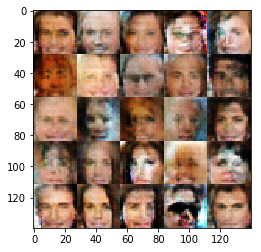

Epoch 1/1 ... Discriminator Loss: 1.3437 Generator Loss: 0.4381
Epoch 1/1 ... Discriminator Loss: 1.5360 Generator Loss: 0.3185
Epoch 1/1 ... Discriminator Loss: 0.9920 Generator Loss: 0.9000
Epoch 1/1 ... Discriminator Loss: 0.9421 Generator Loss: 0.9934
Epoch 1/1 ... Discriminator Loss: 1.5914 Generator Loss: 0.3435
Epoch 1/1 ... Discriminator Loss: 1.2874 Generator Loss: 0.4984
Epoch 1/1 ... Discriminator Loss: 1.2787 Generator Loss: 0.4580
Epoch 1/1 ... Discriminator Loss: 1.2106 Generator Loss: 1.0286
Epoch 1/1 ... Discriminator Loss: 1.2821 Generator Loss: 0.4834
Epoch 1/1 ... Discriminator Loss: 1.1796 Generator Loss: 0.7975


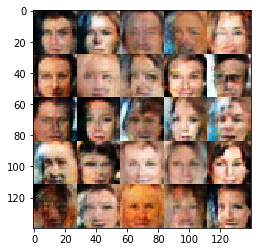

Epoch 1/1 ... Discriminator Loss: 1.2714 Generator Loss: 0.9920
Epoch 1/1 ... Discriminator Loss: 1.4463 Generator Loss: 0.4693
Epoch 1/1 ... Discriminator Loss: 1.0456 Generator Loss: 0.7367
Epoch 1/1 ... Discriminator Loss: 1.5919 Generator Loss: 0.3555
Epoch 1/1 ... Discriminator Loss: 1.3175 Generator Loss: 0.6000
Epoch 1/1 ... Discriminator Loss: 1.0801 Generator Loss: 0.8155
Epoch 1/1 ... Discriminator Loss: 1.0400 Generator Loss: 0.8390
Epoch 1/1 ... Discriminator Loss: 1.7525 Generator Loss: 0.2679
Epoch 1/1 ... Discriminator Loss: 1.4105 Generator Loss: 0.5033
Epoch 1/1 ... Discriminator Loss: 1.0371 Generator Loss: 1.0736


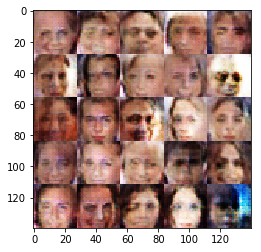

Epoch 1/1 ... Discriminator Loss: 1.1924 Generator Loss: 0.9568
Epoch 1/1 ... Discriminator Loss: 1.1901 Generator Loss: 1.2588
Epoch 1/1 ... Discriminator Loss: 1.5328 Generator Loss: 0.4349
Epoch 1/1 ... Discriminator Loss: 1.0799 Generator Loss: 0.7674
Epoch 1/1 ... Discriminator Loss: 1.7040 Generator Loss: 0.2935
Epoch 1/1 ... Discriminator Loss: 1.0462 Generator Loss: 0.6124
Epoch 1/1 ... Discriminator Loss: 1.4072 Generator Loss: 0.4812
Epoch 1/1 ... Discriminator Loss: 1.1643 Generator Loss: 0.8001
Epoch 1/1 ... Discriminator Loss: 1.2785 Generator Loss: 0.5803
Epoch 1/1 ... Discriminator Loss: 1.2382 Generator Loss: 0.6149


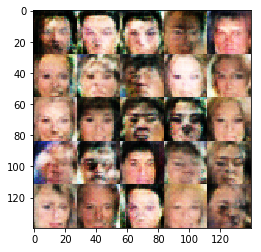

Epoch 1/1 ... Discriminator Loss: 1.1304 Generator Loss: 0.7990
Epoch 1/1 ... Discriminator Loss: 0.9147 Generator Loss: 0.9786
Epoch 1/1 ... Discriminator Loss: 1.4289 Generator Loss: 0.3949
Epoch 1/1 ... Discriminator Loss: 1.0509 Generator Loss: 1.1358
Epoch 1/1 ... Discriminator Loss: 1.3944 Generator Loss: 0.4319
Epoch 1/1 ... Discriminator Loss: 1.2953 Generator Loss: 0.6228
Epoch 1/1 ... Discriminator Loss: 0.9552 Generator Loss: 0.8793
Epoch 1/1 ... Discriminator Loss: 1.4569 Generator Loss: 0.4805
Epoch 1/1 ... Discriminator Loss: 1.2292 Generator Loss: 0.4670
Epoch 1/1 ... Discriminator Loss: 1.3485 Generator Loss: 0.5639


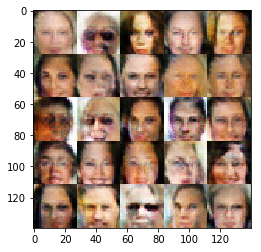

Epoch 1/1 ... Discriminator Loss: 1.7914 Generator Loss: 0.2648
Epoch 1/1 ... Discriminator Loss: 1.2186 Generator Loss: 0.6457
Epoch 1/1 ... Discriminator Loss: 1.1893 Generator Loss: 0.7984
Epoch 1/1 ... Discriminator Loss: 1.5377 Generator Loss: 0.5212
Epoch 1/1 ... Discriminator Loss: 1.5645 Generator Loss: 0.4184
Epoch 1/1 ... Discriminator Loss: 1.1890 Generator Loss: 0.7318
Epoch 1/1 ... Discriminator Loss: 2.0141 Generator Loss: 0.1861
Epoch 1/1 ... Discriminator Loss: 1.5629 Generator Loss: 0.3718
Epoch 1/1 ... Discriminator Loss: 1.5254 Generator Loss: 0.3534
Epoch 1/1 ... Discriminator Loss: 1.1657 Generator Loss: 0.5542


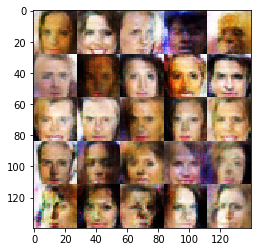

Epoch 1/1 ... Discriminator Loss: 1.1782 Generator Loss: 0.4993
Epoch 1/1 ... Discriminator Loss: 1.9956 Generator Loss: 0.2171
Epoch 1/1 ... Discriminator Loss: 1.2085 Generator Loss: 0.7425
Epoch 1/1 ... Discriminator Loss: 1.1304 Generator Loss: 0.9579
Epoch 1/1 ... Discriminator Loss: 1.3356 Generator Loss: 0.5211
Epoch 1/1 ... Discriminator Loss: 1.1339 Generator Loss: 0.8669
Epoch 1/1 ... Discriminator Loss: 1.1548 Generator Loss: 0.6817
Epoch 1/1 ... Discriminator Loss: 2.1026 Generator Loss: 0.1720
Epoch 1/1 ... Discriminator Loss: 0.9758 Generator Loss: 1.5002
Epoch 1/1 ... Discriminator Loss: 1.2641 Generator Loss: 0.5965


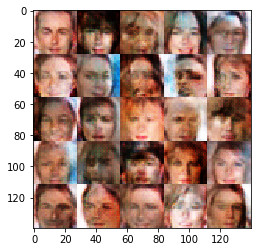

Epoch 1/1 ... Discriminator Loss: 1.4344 Generator Loss: 0.3404
Epoch 1/1 ... Discriminator Loss: 1.4135 Generator Loss: 0.4733
Epoch 1/1 ... Discriminator Loss: 1.3497 Generator Loss: 0.4814
Epoch 1/1 ... Discriminator Loss: 1.1845 Generator Loss: 0.8517
Epoch 1/1 ... Discriminator Loss: 1.4879 Generator Loss: 0.3451
Epoch 1/1 ... Discriminator Loss: 1.2922 Generator Loss: 0.6942
Epoch 1/1 ... Discriminator Loss: 1.2479 Generator Loss: 0.5338
Epoch 1/1 ... Discriminator Loss: 1.2490 Generator Loss: 0.5395
Epoch 1/1 ... Discriminator Loss: 1.1212 Generator Loss: 0.7005
Epoch 1/1 ... Discriminator Loss: 1.1563 Generator Loss: 1.1935


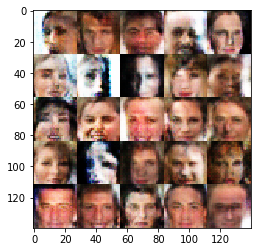

Epoch 1/1 ... Discriminator Loss: 1.8210 Generator Loss: 0.2880
Epoch 1/1 ... Discriminator Loss: 1.1294 Generator Loss: 0.6869
Epoch 1/1 ... Discriminator Loss: 1.3101 Generator Loss: 0.5455
Epoch 1/1 ... Discriminator Loss: 0.9316 Generator Loss: 0.7878
Epoch 1/1 ... Discriminator Loss: 1.4003 Generator Loss: 0.4963
Epoch 1/1 ... Discriminator Loss: 1.5404 Generator Loss: 0.4121
Epoch 1/1 ... Discriminator Loss: 1.2081 Generator Loss: 0.5749
Epoch 1/1 ... Discriminator Loss: 1.2054 Generator Loss: 0.6046
Epoch 1/1 ... Discriminator Loss: 1.2181 Generator Loss: 1.3044
Epoch 1/1 ... Discriminator Loss: 1.1896 Generator Loss: 0.6519


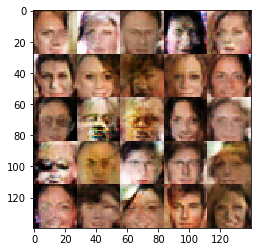

Epoch 1/1 ... Discriminator Loss: 1.1946 Generator Loss: 1.2779
Epoch 1/1 ... Discriminator Loss: 1.6113 Generator Loss: 0.3054
Epoch 1/1 ... Discriminator Loss: 1.2995 Generator Loss: 0.4922
Epoch 1/1 ... Discriminator Loss: 1.1329 Generator Loss: 0.8256
Epoch 1/1 ... Discriminator Loss: 1.1154 Generator Loss: 0.6304
Epoch 1/1 ... Discriminator Loss: 1.5248 Generator Loss: 0.3473
Epoch 1/1 ... Discriminator Loss: 1.1852 Generator Loss: 1.0596
Epoch 1/1 ... Discriminator Loss: 1.0562 Generator Loss: 0.9882
Epoch 1/1 ... Discriminator Loss: 1.0337 Generator Loss: 1.0247
Epoch 1/1 ... Discriminator Loss: 1.1913 Generator Loss: 0.5112


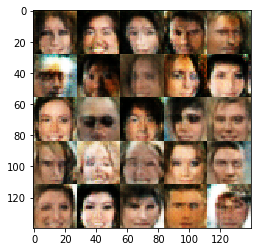

Epoch 1/1 ... Discriminator Loss: 1.3160 Generator Loss: 0.4753
Epoch 1/1 ... Discriminator Loss: 1.4361 Generator Loss: 0.3801
Epoch 1/1 ... Discriminator Loss: 1.5211 Generator Loss: 0.3601
Epoch 1/1 ... Discriminator Loss: 0.9392 Generator Loss: 1.3450
Epoch 1/1 ... Discriminator Loss: 1.5344 Generator Loss: 0.3539
Epoch 1/1 ... Discriminator Loss: 0.5245 Generator Loss: 1.2549
Epoch 1/1 ... Discriminator Loss: 0.0612 Generator Loss: 3.2692
Epoch 1/1 ... Discriminator Loss: 0.0543 Generator Loss: 3.2007
Epoch 1/1 ... Discriminator Loss: 0.0048 Generator Loss: 8.7270
Epoch 1/1 ... Discriminator Loss: 0.0367 Generator Loss: 3.7351


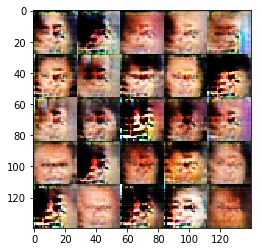

Epoch 1/1 ... Discriminator Loss: 0.0028 Generator Loss: 9.3935
Epoch 1/1 ... Discriminator Loss: 0.0026 Generator Loss: 7.3141
Epoch 1/1 ... Discriminator Loss: 0.0018 Generator Loss: 8.3257
Epoch 1/1 ... Discriminator Loss: 0.1453 Generator Loss: 2.4387
Epoch 1/1 ... Discriminator Loss: 0.5937 Generator Loss: 2.2134
Epoch 1/1 ... Discriminator Loss: 0.8645 Generator Loss: 0.8557
Epoch 1/1 ... Discriminator Loss: 1.0043 Generator Loss: 0.8848
Epoch 1/1 ... Discriminator Loss: 1.1503 Generator Loss: 0.6017
Epoch 1/1 ... Discriminator Loss: 0.9938 Generator Loss: 0.9141
Epoch 1/1 ... Discriminator Loss: 0.8480 Generator Loss: 1.3927


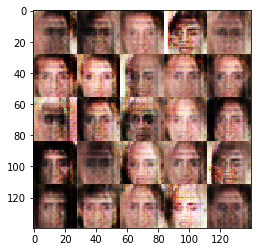

Epoch 1/1 ... Discriminator Loss: 1.1636 Generator Loss: 0.7948
Epoch 1/1 ... Discriminator Loss: 2.2219 Generator Loss: 0.1514
Epoch 1/1 ... Discriminator Loss: 0.6099 Generator Loss: 1.4036
Epoch 1/1 ... Discriminator Loss: 1.0374 Generator Loss: 0.8240
Epoch 1/1 ... Discriminator Loss: 1.1855 Generator Loss: 3.3423
Epoch 1/1 ... Discriminator Loss: 0.8898 Generator Loss: 0.6890
Epoch 1/1 ... Discriminator Loss: 1.0500 Generator Loss: 1.1631
Epoch 1/1 ... Discriminator Loss: 1.1318 Generator Loss: 1.3074
Epoch 1/1 ... Discriminator Loss: 1.2187 Generator Loss: 0.7023
Epoch 1/1 ... Discriminator Loss: 1.7264 Generator Loss: 0.2706


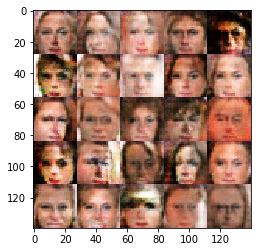

Epoch 1/1 ... Discriminator Loss: 1.3402 Generator Loss: 0.6048
Epoch 1/1 ... Discriminator Loss: 1.2196 Generator Loss: 0.5153
Epoch 1/1 ... Discriminator Loss: 0.8096 Generator Loss: 0.8427


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.005
beta1 = 0.2


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.